# Monte Carlo Simulation with Python and Fantasy Football

## How to think about fantasy football
This analysis is based on three fundamental ideas:

1. Every week, **a player's fantasy score is a random draw from some *distribution*.**

2. The shape of **this distribution is different for every player, every week.**

   What factors go into a player's weekly distribution? Anything that might affect performance (talent, opportunity, quality of the opposing defense, how good the player's offensive line is, weather, etc).

3. Your job as a fantasy football player is to **assemble a lineup of guys with distributions as far to the right as you can.**

   This is what maximizes your probability of winning.

Make sense? If you're skeptical check out the appendix at the end of this document, where we build up the intuition step by step.

## Working with fantasy distributions
So we want to maximize our probability of winning by picking the guys with the best distributions. How might we do that?

### Option 1 for working with distributions: math

The first way to work with distributions is by manipulating certain mathematical equations that — when plotted with X, Y coordinates — make curves.

For example, given some numbers for average $\mu$ and standard deviation $\sigma$, you could draw a Normal distribution by plotting this equation:

$$
f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}}
$$

But there some issues:

- One is that it restricts you to certain types of curves and shapes. This equation is for a Normal distribution. Other equations give other curves with other games. Gamma, Poisson, Weibull, etc. There are a lot of types of curves, but not all data follows these shapes.
- An even bigger bigger problem is that working with the math involved is tedious and difficult at best and literally impossible at worse.

Say I told you Justin Herbert and Patrick Mahomes's projections this week are both normally distributed ~N(18,6) and ~N(20.5,7) respectively.

Quick, using the equation above, tell me — what's the probability Justin Herbert scores more than Patrick Mahomes?

### Option 2 for working with distributions: simulations
Simulations are a much easier way of working with distributions. Analysis that works with simulations is also called **Monte Carlo** analysis.

Technically, simulations are a bunch of draws from some data generating process. Often that process is a mathematical distribution like a Normal or Gamma distribution. But we can also work with data generating processes that are difficult or impossible to describe mathematically. In that case simulations are our only option.

In practice, most simulation analysis involves:

1. **Generating data** according to some process that reflects the aspects of reality you care about. Sometimes this means finding the right distribution, other times it means combining distributions or generating data according to other rules.
2. **Asking questions** and analyzing this simulated data via summary statistics or plots.

Here, I've taken care of (1) for you by modeling thousands of simulated fantasy scores for each player.  In this notebook, we'll go through some cool examples of (2) using this simulation data to ask different questions.

## A note on this document
This is a Jupyter notebook, which is a way to show a mixture of text, tables and Python code.

You don't have to worry about the code (the parts with `In [ ]` next to them). The important thing is they're generating the outputs (the next to `Out[ ]`), which are usually interesting numbers, data tables or graphs that I'll reference out in the text.

Even if you *are* interested in the code you can still read through the document as is, and I'd recommend starting there. Eventually if you want play around with this yourself and change any of the code you have two options:

1. If you have some basic familiarity with Python, Jupyter and Github, you can clone the [repository](https://github.com/nathanbraun/fantasy-monte-carlo) and run it on your local machine. Or
2. You can run the notebook in [binder](https://mybinder.org/v2/gh/nathanbraun/fantasy-monte-carlo/main?filepath=fantasy-monte-carlo.ipynb) (a free, interactive Jupyter notebook viewer) by clicking on the following link:
   
   [https://mybinder.org/v2/gh/nathanbraun/fantasy-monte-carlo/main?filepath=fantasy-monte-carlo.ipynb](https://mybinder.org/v2/gh/nathanbraun/fantasy-monte-carlo/main?filepath=fantasy-monte-carlo.ipynb)

   Note binder takes a few minutes to get set up.

## Monte Carlo Analysis for Week 3, 2023
### Loading the data
Let's look at some player simulations from Week 3, 2023.


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

nsims = pd.read_csv('./data/nsims.csv')
nsims

,patrick-mahomes,jalen-hurts,josh-allen,joshua-dobbs,zach-wilson,lamar-jackson,justin-herbert,tua-tagovailoa,trevor-lawrence,kirk-cousins,...,no,tb,jax,was,den,det,pit,sf,atl,lv
0,31.373173,22.943242,31.278690,5.930377,28.441495,14.373618,24.889975,15.949190,21.141992,36.369677,...,12.254481,1.352437,11.359663,3.107871,3.792302,8.339201,13.518176,11.165673,16.655954,0.079218
1,15.580346,21.278506,18.328942,19.028315,8.589043,24.928424,19.695595,27.723994,7.001144,20.165356,...,9.880197,7.885957,5.417069,6.630614,0.234699,14.633196,14.348552,13.227680,14.725048,7.598453
2,19.305332,20.131436,26.930733,12.247553,10.167820,21.200463,25.814006,23.920744,14.738819,30.615639,...,9.225533,3.289643,27.502175,1.235033,14.118362,6.083915,1.695059,0.826584,0.677490,11.846076
3,5.358195,32.302340,24.790600,9.920325,12.176310,14.476399,14.212815,21.219843,25.647645,12.746029,...,8.700703,6.431883,3.332168,6.274708,4.677788,5.958758,2.251701,15.044705,15.128840,9.830206
4,19.384985,39.341403,21.696812,0.924227,17.978923,22.401451,22.572415,27.873269,19.385690,9.148723,...,0.969503,0.879348,1.998910,3.879241,2.155402,1.202186,5.606427,2.144904,12.699372,13.258936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,29.309151,8.610684,25.650817,25.681485,15.598120,23.251073,18.466861,30.887997,9.937433,28.256653,...,7.856577,8.067598,12.974184,9.499197,1.688407,12.076029,9.860445,10.466341,8.506554,0.583851
496,22.003163,12.419327,19.515395,5.165373,3.792943,25.437858,24.468821,30.496252,19.506345,15.723808,...,13.065573,4.228264,21.554995,2.240510,0.835478,7.838885,0.051396,21.270722,6.544969,33.984122
497,36.987431,33.933994,9.371574,13.204348,8.259211,17.447672,29.982914,30.707705,11.213160,33.280860,...,9.763586,0.066865,12.461045,19.515229,0.805873,29.486924,18.315689,7.870380,12.991355,10.551414
498,36.255033,27.546682,21.582154,5.769464,6.548873,25.852185,18.005356,19.560092,21.850911,16.285168,...,0.272662,1.120690,18.483037,1.635620,4.197196,1.376383,0.430669,0.428591,4.276003,16.353748


This is our simulation data. Each column holds draws from a players distribution, which are numbered (on the side) 0, 1, ... 499. In theory, we could draw as many simulations as we want. To keep things loading fast I've limited each player to 500 simulations.

More info on the players we're simulating — including position, team, and the number of points they actually ended up scoring in week 3, 2023 is here:


In [2]:
players = (pd.read_csv('./data/players.csv')
           .assign(player_id=lambda df: df['player_id'].astype(str))
           .set_index('player_id'))
players.head()

,name,pos,team,actual
player_id,,,,
1091,Patrick Mahomes,QB,KC,25.68
498,Jalen Hurts,QB,PHI,19.88
889,Josh Allen,QB,BUF,21.32
1094,Joshua Dobbs,QB,ARI,17.06
329,Zach Wilson,QB,NYJ,6.38


### Descriptive statistics
So it's week 3, 2023 and we have our data.

Let's take a player, say Justin Herbert. 500 simulations. What can we do with this?

Well, if we're interested in projecting how many points he'll score we could take the average value of our simulations:


In [3]:
print(nsims['justin-herbert'].mean())

21.976058849476672


Or we can look at the median:

In [4]:
print(nsims['justin-herbert'].median())

21.55108079040353


But the real benefit of simulations is how they let you work with distributions. We can get a sense of the distribution with summary statistics:

In [5]:
print(nsims['justin-herbert'].describe(percentiles=[0.05, .25, .5, .75, .95]))

count    500.000000
mean      21.976059
std        8.513235
min        0.606958
5%         9.045559
25%       15.900111
50%       21.551081
75%       27.480257
95%       36.132164
max       49.746482
Name: justin-herbert, dtype: float64


Or by visualizing it:

Text(0.5, 0.98, "Justin Herbert's Fantasy Points Distribution - Wk 3, 2023")

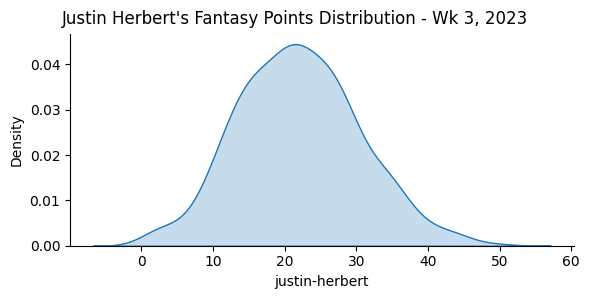

In [6]:
import seaborn as sns
g = sns.FacetGrid(nsims, aspect=2)
g = g.map(sns.kdeplot, 'justin-herbert', fill=True)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Justin Herbert's Fantasy Points Distribution - Wk 3, 2023")


### Will Herbert outscore Mahomes?
Remember above, when I asked for the probability Justin Herbert outscores Mahomes? 

With our data, figuring this out is easy. We have:

In [7]:
nsims[['justin-herbert', 'patrick-mahomes']]

,justin-herbert,patrick-mahomes
0,24.889975,31.373173
1,19.695595,15.580346
2,25.814006,19.305332
3,14.212815,5.358195
4,22.572415,19.384985
...,...,...
495,18.466861,29.309151
496,24.468821,22.003163
497,29.982914,36.987431
498,18.005356,36.255033


Then it's just a matter of — did Herbert outscore Mahomes in our simulations? True or False:

In [8]:
(nsims['justin-herbert'] > nsims['patrick-mahomes'])

0      False
1       True
2       True
3       True
4       True
       ...  
495    False
496     True
497    False
498    False
499     True
Length: 500, dtype: bool

And taking the average (True is 1, False is 0):

In [9]:
print((nsims['justin-herbert'] > nsims['patrick-mahomes']).mean())

0.426


So Herbert is projected to outscore Mahomes 42.6% of the time.

If we wanted to plot this we could do:

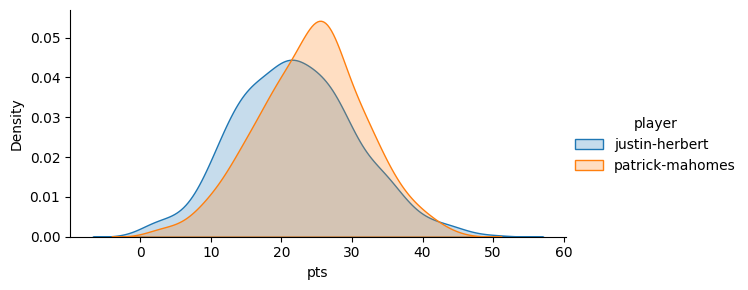

In [10]:
nsims_long = nsims[['justin-herbert', 'patrick-mahomes']].stack().reset_index()
nsims_long.columns = ['sim_n', 'player', 'pts']

g = sns.FacetGrid(nsims_long, hue='player', aspect=2)
g.map(sns.kdeplot, 'pts', fill=True)
g.add_legend()

### Other questions

What else can we ask?

When working with simulations, you're really only limited by your imagination. For example, what's the probability Justin Herbert outscores both Matt Stafford AND Justin Fields by at least 11.5 points?

Can you imagine working with the probability distribution equations above to figure that out mathematically? But, again, with our `nsims` data it's easy:

In [11]:
print((nsims['justin-herbert'] >
         nsims[['matthew-stafford', 'justin-fields']].max(axis=1) + 11.5).mean())

0.158


So about a 16% chance Herbert outscores both Stafford and Fields by at least 11.5 points.

The other benefit: Monte Carlo analysis is flexible. You can take into account whatever you want, as long as you figure out how to build it into the data generating process.

### Projecting best ball distributions
For example, say we're interested in projecting QB points for our best ball team, where we have both Herbert and Matthew Stafford.

This is something that's impossible to figure out numerically, but easy to build into your simulation: 

1. Take a draw from each player, then —
2. Use the higher of the two scores for your QB spot .
3. Analyze that QB score with some basic summary stats.

In this case our data generating process isn't just approximating reality, it's describing it exactly. This is how best ball leagues work.

In [12]:
nsims['bb_qb'] = nsims[['justin-herbert', 'matthew-stafford']].max(axis=1)

nsims[['bb_qb', 'justin-herbert', 'matthew-stafford']].describe()

,bb_qb,justin-herbert,matthew-stafford
count,500.000000,500.000000,500.000000
mean,24.183287,21.976059,15.842432
std,7.519747,8.513235,8.145466
min,4.254415,0.606958,0.027773
25%,19.197732,15.900111,9.984359
50%,23.801324,21.551081,15.836984
75%,28.720037,27.480257,21.395072
max,49.746482,49.746482,40.711039


So on average, we'd expect a best ball duo of Herbert and Stafford to score about 24.18 points, vs 21.98 and 15.84 for Herbert and Stafford individually.

What if we want to see how much adding Kirk Cousins would raise our score?

In [13]:
nsims['bb_qb2'] = nsims[['justin-herbert', 'matthew-stafford', 'kirk-cousins']].max(axis=1)

nsims[['bb_qb2', 'bb_qb', 'justin-herbert', 'matthew-stafford', 'kirk-cousins']].describe().round(2)

,bb_qb2,bb_qb,justin-herbert,matthew-stafford,kirk-cousins
count,500.00,500.00,500.00,500.00,500.00
mean,27.03,24.18,21.98,15.84,21.64
std,7.01,7.52,8.51,8.15,8.15
min,12.35,4.25,0.61,0.03,0.37
25%,22.15,19.20,15.90,9.98,16.07
50%,26.38,23.80,21.55,15.84,20.99
75%,31.69,28.72,27.48,21.40,26.96
max,52.09,49.75,49.75,40.71,52.09


That brings the average up 3 points, to 27.

By modifying the data generating process and drawing a bunch of simulations, we're able to answer questions about our data it'd be impossible to figure out any other way.

It's also interesting to plot these distributions:

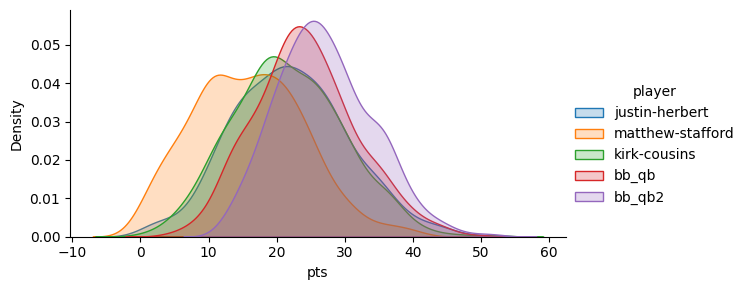

In [14]:
nsims_long = nsims[['justin-herbert', 'matthew-stafford', 'kirk-cousins', 'bb_qb', 'bb_qb2']].stack().reset_index()
nsims_long.columns = ['sim_n', 'player', 'pts']

g = sns.FacetGrid(nsims_long, hue='player', aspect=2)
g.map(sns.kdeplot, 'pts', fill=True)
g.add_legend()

### Actual scores vs projections
Because we're looking at data from last year, we know how many points these players actually scored, it's the `actual` column of our player data:

In [15]:
players

,name,pos,team,actual
player_id,,,,
1091,Patrick Mahomes,QB,KC,25.68
498,Jalen Hurts,QB,PHI,19.88
889,Josh Allen,QB,BUF,21.32
1094,Joshua Dobbs,QB,ARI,17.06
329,Zach Wilson,QB,NYJ,6.38
...,...,...,...,...
5161,DET,DST,DET,16.00
5177,PIT,DST,PIT,14.00
5179,SF,DST,SF,8.00


So Mahomes scored 25.68 points in Week 2, 2023. How does that compare with what we simulated for him beforehand?

Well, our median Mahomes simulation was:

In [16]:
print(nsims['patrick-mahomes'].median())

24.493723591765647


So it's pretty close.

What about percentile-wise?

In [17]:
print((25.68 > nsims['patrick-mahomes']).mean())

0.56


So Mahomes score in Week 3 beat 56% of his simulations, i.e. it was a *56th percentile* score.

Let's get projected score — by taking the average of the simulations — for all the quarterbacks.

(Note to do that I'm loading in another copy of our simulation data `sims` that's exactly the same as `nsims`, but with `player_id` as the column titles instead of `first-last` name.)

In [18]:
sims = pd.read_csv('./data/sims.csv')

qbs = players.loc[players['pos'] == 'QB']
qbs['proj'] = sims.mean().round(2)

qbs.sort_values('proj', ascending=False).head(15)[['name', 'proj', 'actual']]


,name,proj,actual
player_id,,,
1091,Patrick Mahomes,24.11,25.68
494,Justin Herbert,21.98,29.30
2085,Kirk Cousins,21.64,25.68
498,Jalen Hurts,21.35,19.88
893,Lamar Jackson,21.24,28.18
889,Josh Allen,21.01,21.32
493,Tua Tagovailoa,19.95,28.36
327,Trevor Lawrence,19.10,14.36
1297,Dak Prescott,18.67,14.36


Now let's calculate each quarterback's percentile too:

In [19]:
def fpts_pctile(row):
    return (row['actual'] > sims[str(row.name)]).mean()

qbs['pctile'] = qbs.apply(fpts_pctile, axis=1)

Here are the top 15 projected QBs and how they did:

In [20]:

qbs.sort_values('proj', ascending=False).head(15)[['name', 'proj', 'actual', 'pctile']]


,name,proj,actual,pctile
player_id,,,,
1091,Patrick Mahomes,24.11,25.68,0.560
494,Justin Herbert,21.98,29.30,0.808
2085,Kirk Cousins,21.64,25.68,0.694
498,Jalen Hurts,21.35,19.88,0.394
893,Lamar Jackson,21.24,28.18,0.808
889,Josh Allen,21.01,21.32,0.536
493,Tua Tagovailoa,19.95,28.36,0.854
327,Trevor Lawrence,19.10,14.36,0.246
1297,Dak Prescott,18.67,14.36,0.284


So Justin Herbert scored 29.30 points vs his projection of 21.98. About an 80th percentile week.  We'd expect to see an 80th performance about 1 out of every 5 times. And sure enough, if you look at the 15 players above, three of them (Herbert, Lamar Jackson, Deshaun Watson) have a `pctile` > 80.

Similarly, we should expect to see 10% of the players under 10 pctile, 20% under 20, etc. And actually it's pretty close:

In [21]:
qbs['pctile'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).round(2)

count    31.00
mean      0.49
std       0.26
min       0.01
10%       0.14
20%       0.23
30%       0.29
40%       0.39
50%       0.52
60%       0.56
70%       0.69
80%       0.74
90%       0.81
max       0.89
Name: pctile, dtype: float64

14% of players had 10th percentile or less draws, 23% of players, 20th percentile, etc.

This is the sign of a good model.

### Percentiles as luck

A player's actual point percentile is one way to quantify "luck".

Good draws from further right in the distrubution have higher percentiles, and are luckier. Worse draws, from further left, are unlucky.

Let's look at the top 10 luckiest fantasy QB performances in Week 3, 2023:

In [22]:
qbs.sort_values('pctile', ascending=False).head(10)[['name', 'proj', 'actual', 'pctile']]

,name,proj,actual,pctile
player_id,,,,
497,Jordan Love,14.49,24.26,0.892
2301,Andy Dalton,12.94,23.54,0.884
493,Tua Tagovailoa,19.95,28.36,0.854
1094,Joshua Dobbs,11.12,17.06,0.808
893,Lamar Jackson,21.24,28.18,0.808
494,Justin Herbert,21.98,29.30,0.808
150,Kenny Pickett,13.83,18.50,0.738
1757,Jimmy Garoppolo,13.19,17.66,0.716
1088,Deshaun Watson,17.25,21.16,0.706


(Aside: remember — this is from week 3, 2023. *Now* in 2024, we know Jordan Love is good (he just became the highest paid QB ever). But these distributions were built using the best information we had in September 2023. Back then opinions about Love were much more up in the air, which meant his projected distribution was further to the left. So while Love might have been good the whole time, and his success isn't "luck" from his POV, you were indeed lucky (or ahead of the fantasy consensus) to get these kind of points out of Love back in early 2023.)

And here are the unluckiest players:

In [23]:
qbs.sort_values('pctile', ascending=True).head(10)[['name', 'proj', 'actual', 'pctile']]

,name,proj,actual,pctile
player_id,,,,
151,Sam Howell,13.30,0.60,0.014
677,Daniel Jones,14.63,3.98,0.082
492,Joe Burrow,17.24,8.16,0.136
2082,Ryan Tannehill,11.63,4.16,0.140
328,Justin Fields,17.56,10.66,0.206
155,Desmond Ridder,12.83,6.34,0.216
1689,Derek Carr,14.40,8.12,0.232
327,Trevor Lawrence,19.10,14.36,0.246
1297,Dak Prescott,18.67,14.36,0.284


(Note you could reverse what we Love above and apply it to someone like Fields or Lawrence)

### Would you rather be lucky or good?
Would you rather be lucky or good? Well it depends.

Patrick Mahomes is good. He has a very rightward projected point distribution.

He wasn't particularly lucky in week 3, with a 56th percentile draw.

But because he's good, that still meant 25.68 points. Meanwhile, Andy Dalton was very lucky in week 3 (88th percentile draw), but since he's not that good (the median of his distribution is about 13 points) he still scored less than Mahomes.

So really, the best performing players are usually lucky *and* good. We can see that by looking at the top performers:


In [24]:
qbs.sort_values('actual', ascending=False).head(10)[['name', 'proj', 'actual', 'pctile']]

,name,proj,actual,pctile
player_id,,,,
494,Justin Herbert,21.98,29.30,0.808
493,Tua Tagovailoa,19.95,28.36,0.854
893,Lamar Jackson,21.24,28.18,0.808
1091,Patrick Mahomes,24.11,25.68,0.560
2085,Kirk Cousins,21.64,25.68,0.694
497,Jordan Love,14.49,24.26,0.892
2301,Andy Dalton,12.94,23.54,0.884
889,Josh Allen,21.01,21.32,0.536
1088,Deshaun Watson,17.25,21.16,0.706


Two of the top three are good QBs (Herbert and Lamar) who got fairly lucky (80th percentile) draws. There's also Tua, who is a bit less good but got an even luckier draw (85th percentile). Then there's Mahomes.

In reality, high score are a combo of luck *and* skill. But, since you can't predict luck, you should just focus on the skill part, which is what you do when you start players with the best distributions. 

## Correlations
One of the most useful things about these simulations is that they're correlated.

Correlation summarizes the tendency of numbers to move together. The usual way of calculating correlation (Pearson's) summarizes this tendency by giving you a number between -1 and 1.

Variables with a -1 correlation move perfectly in opposite directions; variables that move in the same direction have a correlation of 1. A correlation of 0 means the variables have no relationship.

For example, the correlation between a QB and his WR1 is about 0.40. As quarterbacks tend to score more, their WR1's tend to score more too. It's not a sure thing — it's possible the QB had a big game by throwing to his WR2 or his TE — but their scores tend to move together.

You can see here that the projections for Herbert and Keenan Allen — though the data is purely simulated — have a correlation around 0.40, just like it'd be in real life.


In [25]:
nsims[['justin-herbert', 'keenan-allen']].corr()

,justin-herbert,keenan-allen
justin-herbert,1.000000,0.400943
keenan-allen,0.400943,1.000000


Same with Herbert and the DST he was playing against (Vikings this week) — except the correlation between a QB and the DST he's playing against is even stronger, and negative:

In [26]:
nsims[['justin-herbert', 'min']].corr()

,justin-herbert,min
justin-herbert,1.000000,-0.547627
min,-0.547627,1.000000


Note: these correlated projections definitely aren't an accident or something that just happened. It took a lot of work behind the scenes to (a) figure out what these historical correlations between players in the same game were, (b) come up with a way to simulate draws from players while preserving them, and (c) make sure the distributions were accurate overall.

It's turned out well. We ran these separately above, but what's great about these projections is that they're all correlated *simultaneously*, that is — Herbert is positively correlated with Keenan Allen (and Ekeler, Mike Williams and his K etc) and negatively correlated with the Vikings DST, *all at the same time.*

In [27]:
nsims[['justin-herbert', 'keenan-allen', 'min']].corr()

,justin-herbert,keenan-allen,min
justin-herbert,1.000000,0.400943,-0.547627
keenan-allen,0.400943,1.000000,-0.236117
min,-0.547627,-0.236117,1.000000


You can see Keenan is also negatively correlated with the Minnesota D, but not as much as Herbert.

Let's add a few more:

In [28]:
nsims[['justin-herbert', 'kirk-cousins', 'keenan-allen', 'justin-jefferson', 'min', 'jordan-love']].corr().round(2)

,justin-herbert,kirk-cousins,keenan-allen,justin-jefferson,min,jordan-love
justin-herbert,1.00,0.22,0.40,0.10,-0.55,-0.01
kirk-cousins,0.22,1.00,0.09,0.27,-0.07,-0.03
keenan-allen,0.40,0.09,1.00,0.11,-0.24,-0.01
justin-jefferson,0.10,0.27,0.11,1.00,-0.08,-0.04
min,-0.55,-0.07,-0.24,-0.08,1.00,-0.04
jordan-love,-0.01,-0.03,-0.01,-0.04,-0.04,1.00


We can see Herbert and Cousins — opposing QBs — are positively correlated. Many times (not every time, otherwise the correlation would be 1) gameflow leads to QBs either both doing well (e.g. a shootout) or poorly (e.g. a grind out game).

I also added Jordan Love (who was playing the Saints) so you can see he's not correlated with anyone at all. His correlations with all the LAC-LV players are around around 0 (they're not perfectly 0 since there's noise in the data). This makes sense, since he's playing hundreds of miles away.

### Conditional Probabilities
Another way of seeing how these correlations affect players scores is by looking at *conditional* probabilities. For example, with PPR scoring in week 3, 2023, Keenan Allen's regular, unconditional projected points distribution looked like this:

In [29]:
nsims['keenan-allen'].describe().round(2)

count    500.00
mean      17.49
std        9.45
min        0.10
25%       10.33
50%       16.81
75%       24.96
max       44.55
Name: keenan-allen, dtype: float64

But what if we want to know Allen's range of outcomes, *conditional* on Herbert scoring at least 30 points, an then again when Herbert scores 12 or less.

The fact that their simulations are positively correlated means these distributions will be higher and lower respectively:

In [30]:
pd.concat([
    nsims.loc[nsims['justin-herbert'] > 30, 'keenan-allen'].describe(),
    nsims.loc[nsims['justin-herbert'] < 12, 'keenan-allen'].describe()], axis=1)

,keenan-allen,keenan-allen
count,83.000000,57.000000
mean,24.816760,11.357782
std,9.114331,7.474711
min,0.425437,0.330261
25%,19.976145,4.729811
50%,25.946795,11.630839
75%,30.683469,16.518819
max,42.979666,29.838108


### Who should I start Monday night?
Factoring in these correlations (along with the shape of a players point distribution generally) allows us to be more precise with the type of questions we want to answer.

For example, say I was going into MNF week 3, 2023 wondering who should I start: Mike Evans or Tee Higgins?

In terms of a simple, "who will score more points?" the simulations say Evans.

In [31]:
(nsims['mike-evans'] > nsims['tee-higgins']).mean()

np.float64(0.564)

And that's fine. But again, it's Monday night, so most guys have played. What if I'm down 40 points and I also have Joe Burrow?

In [32]:
(nsims[['joe-burrow', 'mike-evans']].sum(axis=1) > 50).mean()

np.float64(0.064)

In [33]:
(nsims[['joe-burrow', 'tee-higgins']].sum(axis=1) > 50).mean()

np.float64(0.09)

My chances with Higgens (9%) and Burrow much better than my chances with Mike Evans (6%) and Burrow, even though Evans usually scores more. This is what taking positional correlations into account allows you to do.

### Playing "offense" or "defense" as the underdog or favorite
Let's look at a simplified fantasy matchup. Say we're in a 1 QB, 1 DST league. Our opponent this week is good, with Justin Herbert (2nd ranked QB) and the Cowboys Defense (3rd ranked DST).  Our QB is the solidly average (10th ranked QB) Geno Smith, and our DST options aren't great either. We're trying to decide whether to start the Steelers (ranked 16) or Minnesota (ranked 19).

Pittsburgh DST averages more points than the Vikings DST:

In [34]:
nsims[['min', 'pit']].describe()

,min,pit
count,500.000000,500.000000
mean,7.078593,7.657250
std,5.308242,6.036458
min,0.008882,0.026179
25%,2.772932,2.548929
50%,6.077938,6.454133
75%,10.293269,11.583480
max,27.438368,31.974950


In a vacuum, we'd definitely start them. But the Vikings D is playing against Herbert this week, so their scores are negatively correlated. If Herbert has a bad game, the Vikings D is more likely to have a *good* game, and vis versa. Pittsburgh (who is playing the Raiders) is uncorrelated (the ~0.03 correlation is noise).

In [35]:
nsims[['justin-herbert', 'min', 'pit']].corr()

,justin-herbert,min,pit
justin-herbert,1.000000,-0.547627,0.034049
min,-0.547627,1.000000,-0.030473
pit,0.034049,-0.030473,1.000000


Because we're the heavy underdog (Geno and a not great D vs Herbert and the top ranked D), the negative correlation between MIN and Herbert helps us. Basically, we're down so much that we need two things to go "right" for us to win: a bad Herbert game for our opponent, *and* a good DST game from us. Both of those together are more likely to happen when we start the Vikings. And we can see it in the data:

In [36]:
print((nsims[['geno-smith', 'pit']].sum(axis=1) > nsims[['justin-herbert', 'dal']].sum(axis=1)).mean())

0.312


In [37]:
print((nsims[['geno-smith', 'min']].sum(axis=1) > nsims[['justin-herbert', 'ne']].sum(axis=1)).mean())

0.324


Starting the Vikings gives us slightly better odds, even though Pittsburgh is the better D.

Again, this is only because we're a heavy underdog. What happens if we replace Geno with Mahomes?

In [38]:
print((nsims[['patrick-mahomes', 'pit']].sum(axis=1) > nsims[['justin-herbert', 'dal']].sum(axis=1)).mean())

0.49


In [39]:
print((nsims[['patrick-mahomes', 'min']].sum(axis=1) > nsims[['justin-herbert', 'dal']].sum(axis=1)).mean())

0.454


Now we can see the Vikings are the much worse option, lowering our odds almost 4 percentage points.

# Appendix - Fantasy points as distributions
Here’s a quick set of numbers –

17... 24...  8...  4... 13... 12...  0... 15... 14... 13... 11...  7... 0...
8... 17... 23...  2... 15...  9...  4... 28...  5...  9...  5... 17...

These are 25 randomly selected weekly RB performances from 2019. The first is
Todd Gurley's 17 point performance in week 16, the second is Derrick Henry's 24
point performance week 14, etc.

Ok. Now let’s arrange these from smallest (0) to largest (28), marking each
with an **x** and stacking **x**‘s when a score shows up multiple times. Make
sense? That gives us something like this:

![25 random RB performances in 2019](fig/rb_25.png)

Interesting, but why should we limit ourselves to just 25 games? Let’s see
what it looks like when we plot ALL the RB’s over ALL their games:

![Stacked X's for all RB performances in 2019](fig/rb_all.png)

This is the first key to thinking probabilistically about fantasy football:

**For any given week, when you start a player you’re picking out one of these
little x's at random.**

Each `x` is equally likely to get picked. Each *score*, however, is not.
There are a lot more `x`'s between 0-10 points than there are between 20 and
30.

### Distributions: Smoothed Out X's
Now let's switch from stacked x's to curves, which are easier to deal with
mathematically.

![All RB performances in 2019 - Curves](fig/rb_curve.png)

The curve above is called a *distribution*. For our purposes, they're a way to
smooth things out. We're replacing the stacked x's with a fuzzier, smoothed
out curve. You can continue to imagine the area under these curves as filled
up with little, stacked up x's if you want.

The horizontal axis on this curve still represents fantasy points. The
vertical axis is less intuitive, but it ensures the area under the curve
equals 1.  Don't worry about it this if it's confusing.

So you’re heading into the Monday night game up by 10 points. Your team is
done and the guy you’re playing only has one RB left — how likely is it you
come out with a win?

The answer — assuming your opponent is starting a random RB — is about 50/50.
Half of the area under the distribution (half of the little x's in Figure 2)
is at 11 points or higher, half is below.

That's if your opponent is starting a random running back. What if he's
starting Ezekiel Elliot?

Zeke is not some random RB. His score is, on average, higher than average,
which means his distribution is further to the right. Something like the red
one below. 

![All RBs plus Zeke](fig/rb_curve_w2.jpg)

In that case, Zeke will score more than 10 points 90% of the time and things
aren't looking good for Monday night.

This is important: **the shape of probability distribution changes for any
given player and week**.

A lot goes into these distributions: offensive line, quality of the defense,
number of touches, whether the RB is in a committee, etc.

Your job as a fantasy player: assemble a lineup of guys with distributions far
to the right.

This maximizes your chances of winning. Does this mean you'll always win or
start the right guy?

Of course not. Even above, a draw from a random RB's distribution (the blue
line) will be higher than a draw from Zeke's about 20% of the time. But it
will put you in the best position to maximize your odds.

The key is changing how you view player-performances. They're not taken out of
thin air, or something to be rationalized and fit into a narrative (I KNEW
this [guy who performed poorly] was bad, never again!). That's a recipe for
frustration and chasing points.

Instead, view performances as random draws from some range of outcomes.
This captures the randomness inherent in Fantasy Football, is a good model for
what's actually happening behind the scenes, and is a way to stay sane.
